# HDB Resale Price Predictor & Visualisation
## Model Building

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb 
import joblib
import os

plt.style.use("fivethirtyeight")
os.chdir('f:/Natuyuki/Dropbox/Gitstuff/ml_webapp')
print(f'Working directory: {str(os.getcwd())}')

Working directory: f:\Natuyuki\Dropbox\Gitstuff\ml_webapp


In [39]:
df = pd.read_csv('static/train.csv', index_col=0)
display(df.head())
print(df.shape)

,resale_price,year,month,timeseries_month,region,town,rooms,avg_storey,floor_area_sqm,remaining_lease,address,dist_to_marina_bay,latitude,longitude,postal_code,nearest_station_0,dist_to_station_0
_id,,,,,,,,,,,,,,,,,
159201,433000.0,2023,8,2023-08-01,West,Jurong East,4.0,2.0,91.0,57.583333,"236, Jurong East Street 21",14.63,1.340407,103.742129,600236,Jurong East MRT,0.80
158903,825000.0,2023,8,2023-08-01,Central,Central Area,4.0,26.0,83.0,55.833333,"8, Tg Pagar Plaza",2.11,1.277273,103.842917,80008,Tanjong Pagar MRT,0.32
158902,1220000.0,2023,8,2023-08-01,Central,Central Area,4.0,20.0,93.0,86.500000,"1B, Cantonment Road",2.25,1.277799,103.841403,85201,Outram Park MRT,0.30
158901,1410000.0,2023,8,2023-08-01,Central,Central Area,4.0,50.0,94.0,86.500000,"1B, Cantonment Road",2.25,1.277799,103.841403,85201,Outram Park MRT,0.30
158900,1320000.0,2023,8,2023-08-01,Central,Central Area,4.0,47.0,93.0,86.500000,"1G, Cantonment Road",2.34,1.275532,103.841275,85701,Tanjong Pagar MRT,0.51


(16975, 17)


# Model Building
1. <a href='#1'>EDA</a>
2. <a href='#2'>Model Building</a>
3. <a href='#3'>Conclusions</a>

## <div id ='1'>1. EDA</div>

<a href='#1.1'>1.1 Handling null values</a>

<a href='#1.2'>1.2 Checking for collinearity</a>

<a href='#1.3'>1.3 Exploring the dataset</a>

### Explanation for each feature

| Feature*           | Explanation                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| resale_price      | Dependent variable, the selling price of the flat                                               |
| region            | Region of the flat                                                                              |
| town              | Town district of the flat                                                                       |
| rooms             | Number of rooms in the flat (whole numbers except for 5.5, which represents an executive flat with an extra study/balcony) |
| avg_storey        | Mean value of the floor range (intervals of 3 storeys)                                          |
| floor_area_sqm    | Total floor area (in square meters) of the flat                                                 |
| remaining_lease   | Remaining lease of the flat in months                                                           |
| dist_to_marina_bay| Distance in absolute coordinates to Marina Bay (proxy to city center)                           |
| dist_to_station   | Distance in meters to the nearest MRT (Mass Rapid Transit) station                              |

*Other features not listed above but in DataFrame are for visualisation purposes

###  <div id ='1.1'>1.1 Handling null values</div>

Double check for null values, drop if any present

In [40]:
display(df.isna().sum())
df.dropna(inplace=True)

resale_price          0
year                  0
month                 0
timeseries_month      0
region                0
town                  0
rooms                 0
avg_storey            0
floor_area_sqm        0
remaining_lease       0
address               0
dist_to_marina_bay    0
latitude              0
longitude             0
postal_code           0
nearest_station_0     0
dist_to_station_0     0
dtype: int64

### <div id="1.2">1.2 Checking for collinearity among numerical features</div>
* There is strong collinearity between 
    * floor_area_sqm and rooms (0.86)
* Even much so higher than their correlation with output (resale price)
* For linear models, we need to remove one of each pair of feature to ensure that there is no multicollinearity, for this I will remove the feature with lower Pearson's correlation with our output
    * rooms (0.65)

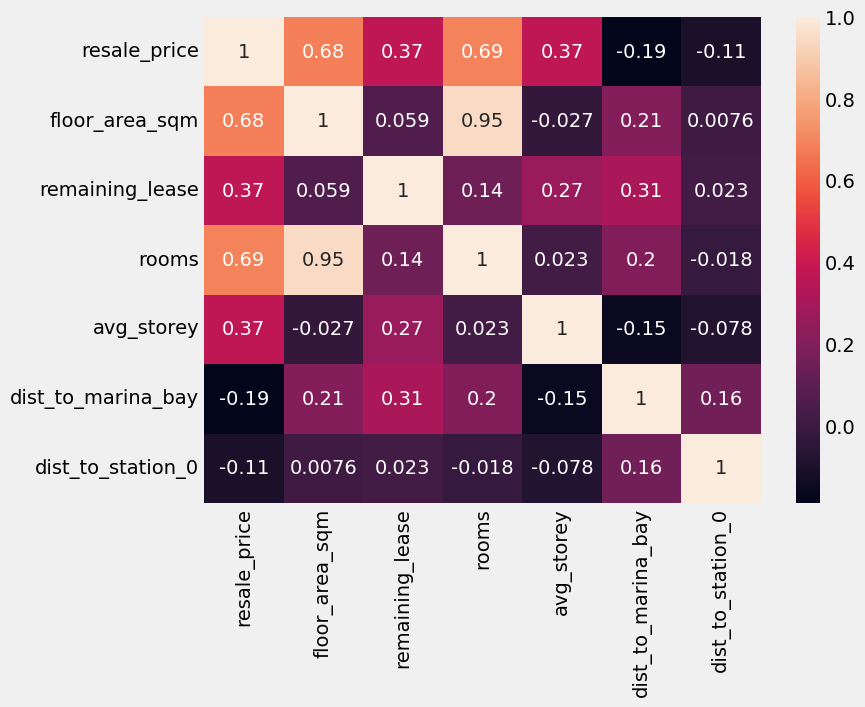

In [41]:
plt.figure(figsize=(8,6))
numerical_columns = df[['resale_price', 'floor_area_sqm', 'remaining_lease', 'rooms', 'avg_storey', 'dist_to_marina_bay', 'dist_to_station_0']]
sns.heatmap(numerical_columns.corr(), annot=True)
plt.show()

### <div id="1.3">1.3 Exploring the dataset</div>
#### Which are the most expensive regions and neighbourhoods?

Each neighbourhood has different valuations due to a non-exhaustive number of factors:

* location
* infrastructure and amenitites
* affluent / less affluent neighbourhoods
* supply and demand
* market speculation  

We can see that flats in the Central region have the highest mean prices, while those in the North region have the lowest mean prices.

In [47]:
region_prices = df.groupby(['region', 'rooms'])[['resale_price']].mean(numeric_only=True).sort_values(by=['region','rooms'], ascending=False)
region_prices = region_prices.unstack()
region_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive / Multigenerational']
region_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

,1 room,2 room,3 room,4 room,5 room,Executive / Multigenerational
region,,,,,,
Central,"242,667","299,261","433,617","757,014","897,744","1,029,406"
East,nan,"330,900","397,500","565,193","686,898","850,218"
North,nan,"324,012","390,556","502,042","609,651","803,989"
North-East,nan,"330,254","417,009","576,651","672,219","828,667"
West,nan,"321,308","395,104","536,900","645,290","768,555"


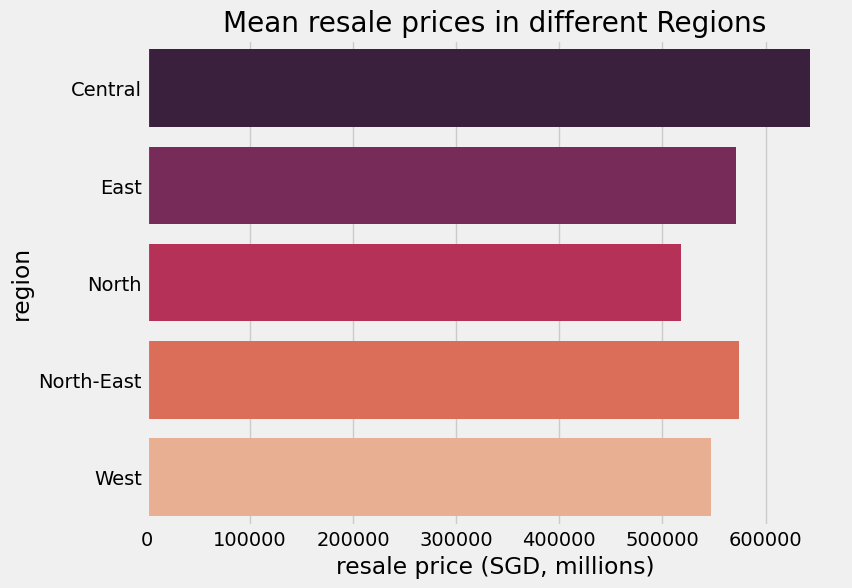

In [46]:
plt.figure(figsize=(8,6))
region_prices = df.groupby(['region'])[['resale_price']].mean(numeric_only=True).reset_index()
sns.barplot(data=region_prices,  x='resale_price', y='region', orient='h', palette='rocket')
plt.title('Mean resale prices in different Regions')
plt.xlabel('resale price (SGD, millions)')
plt.show()

This is consistent even as we breakdown the region into towns. Towns in the Central region have the highest mean resale prices. 

As shown below.

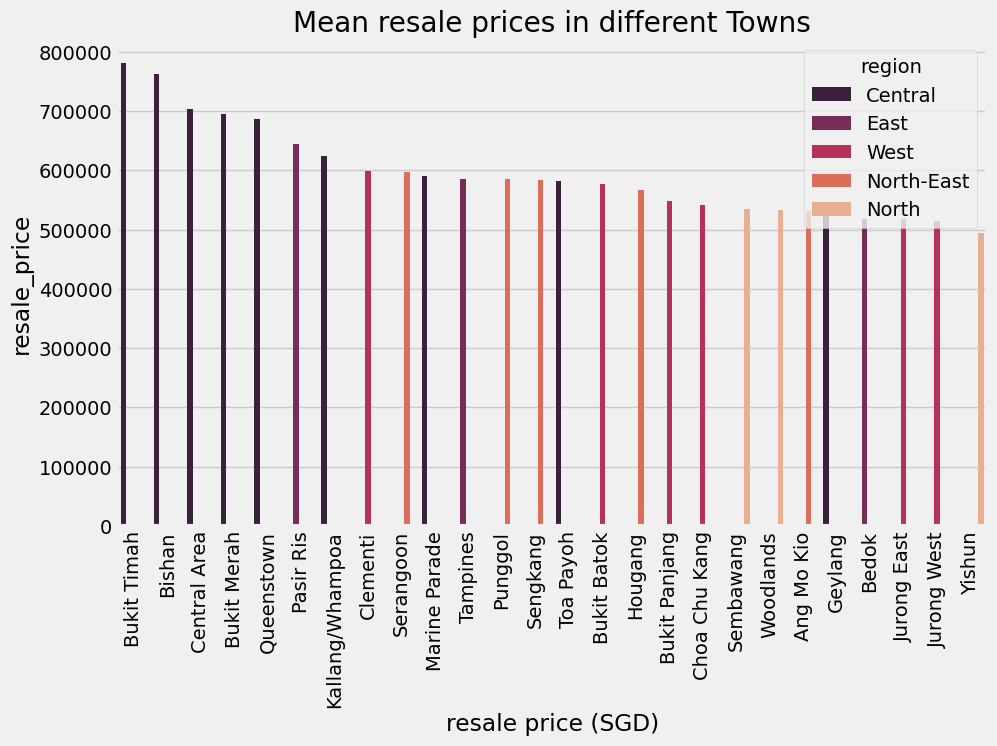

In [43]:
town_regions = {'Sembawang' : 'North',
                'Woodlands' : 'North',
                'Yishun' : 'North',
                'Ang Mo Kio' : 'North-East',
                'Hougang' : 'North-East',
                'Punggol' : 'North-East',
                'Sengkang' : 'North-East',
                'Serangoon' : 'North-East',
                'Bedok' : 'East',
                'Pasir Ris' : 'East',
                'Tampines' : 'East',
                'Bukit Batok' : 'West',
                'Bukit Panjang' : 'West',
                'Choa Chu Kang' : 'West',
                'Clementi' : 'West',
                'Jurong East' : 'West',
                'Jurong West' : 'West',
                'Tengah' : 'West',
                'Bishan' : 'Central',
                'Bukit Merah' : 'Central',
                'Bukit Timah' : 'Central',
                'Central Area' : 'Central',
                'Geylang' : 'Central',
                'Kallang/Whampoa' : 'Central',
                'Marine Parade' : 'Central',
                'Queenstown' : 'Central',
                'Toa Payoh' : 'Central'} 

figure = plt.figure(figsize=(10,6))
town_prices = df.groupby(['town'])[['resale_price']].mean(numeric_only=True).sort_values(by=['resale_price'], ascending=False).reset_index()
town_prices['region'] = town_prices['town'].map(town_regions)
sns.barplot(data=town_prices,  x='town', y='resale_price', hue='region', palette='rocket')
plt.title('Mean resale prices in different Towns')
plt.xlabel('resale price (SGD)')
plt.xticks(rotation = 90)
plt.show()

Number of rooms are also a good quantifier of the resale price, we see that the mean resale prices for different rooms follow a certain range (irregardless of region)
While expensive regions have a higher upper range of mean resale price.

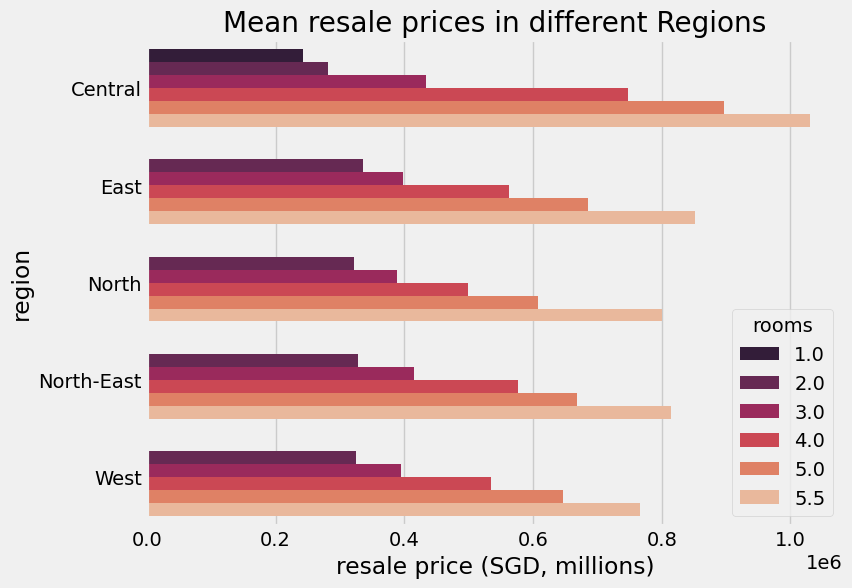

In [33]:
plt.figure(figsize=(8,6))
region_prices = df.groupby(['region', 'rooms'])[['resale_price']].mean(numeric_only=True).reset_index()
sns.barplot(data=region_prices,  x='resale_price', y='region', hue='rooms', orient='h', palette='rocket')
plt.title('Mean resale prices in different Regions')
plt.xlabel('resale price (SGD, millions)')
plt.show()

Breaking it down into town and rooms

In [44]:
# town_prices = df.groupby(['town', 'rooms'])[['resale_price']].mean(numeric_only=True).sort_values(by=['town','rooms'], ascending=False)
# town_prices = town_prices.unstack()
# town_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive / Multigenerational']
# town_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

#### Change in resale prices within year 2023

The prediction of resale prices over time should be a timeseries problem.

Here we are only looking at a short span of time, and the prices have not moved significantly much, we will do away with timeseries models for simplicity.

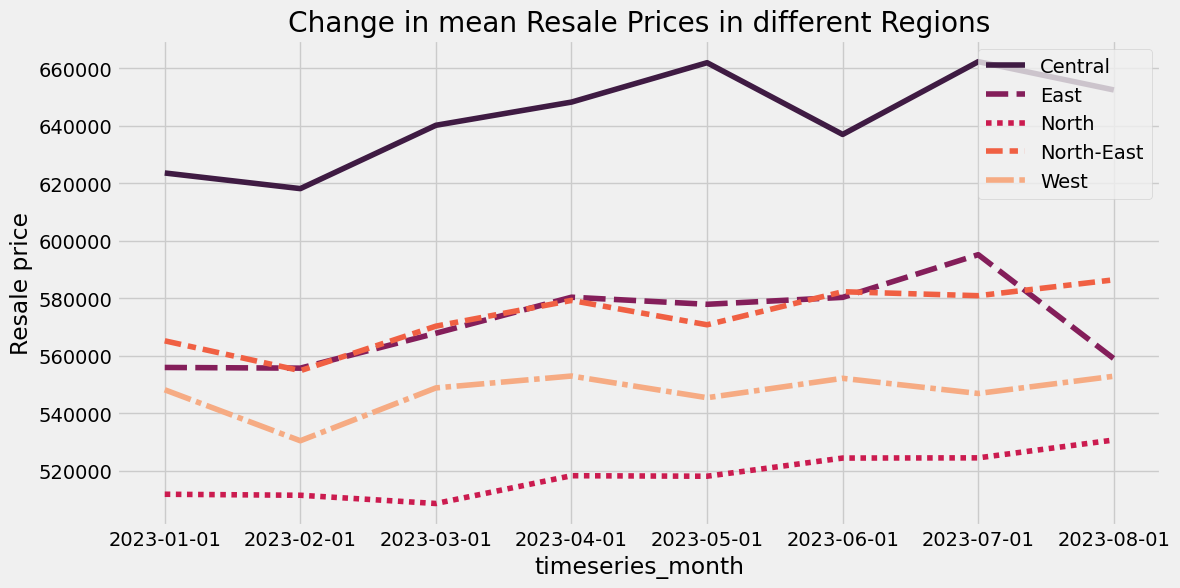

In [53]:
ma_df = df.groupby(['timeseries_month', 'region'])['resale_price'].mean()
ma_df = ma_df.unstack()
plt.figure(figsize=(12,6))
sns.lineplot(data=ma_df, palette='rocket')
plt.title('Change in mean Resale Prices in different Regions')
plt.ylabel('Resale price')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Calculate change over time

## <div id="2">2. Model Building</div>
<a href='#2.1'>2.1 Outlier Handling and Preprocessing (label and mean encoding)</a>

<a href='#2.2'>2.2 Feature selection (KBest, Lasso regression)</a>

<a href='#2.3'>2.3 Model selection</a>

<a href='#2.4'>2.4 Hyperparameter tuning </a>

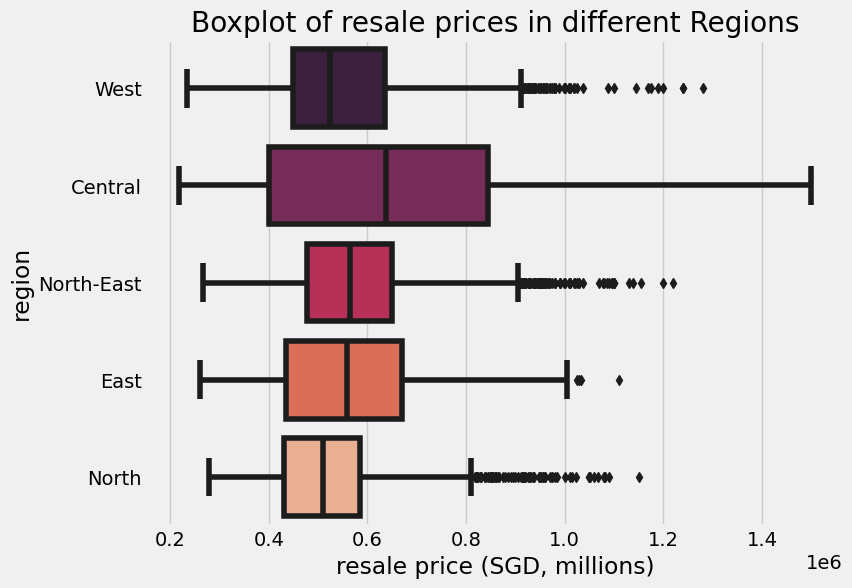

In [48]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df,  x='resale_price', y='region', orient='h', palette='rocket')
plt.title('Boxplot of resale prices in different Regions')
plt.xlabel('resale price (SGD, millions)')
plt.show()

### <div id="2.1">2.1 Outlier Handling and Preprocessing (label and mean encoding)</div>
* I will perform both label and mean encoding (resale_price) onto the town and rooms.
* Since all of them overlap, I will only use one of these encodings in the end, based on how well the feature generate is.
* Take note that mean encoding may sometimes result in overfitting.

In [36]:
# Label encoding for town
encoder = LabelEncoder()
town_label = pd.Series(encoder.fit_transform(df['town']), name='town_encoded', index=df.index)

# Label encoding for region
region_label = pd.Series(encoder.fit_transform(df['region']), name='region_encoded', index=df.index)

There is no in-built encoders in Sklearn for Mean/Median encoding, for the purpose of deployment later, I will write my own custom class for Mean/Median encoding.

In [37]:
class MeanEncoder():
    '''
    Custom class encoder to deal with mean/median encoding
    '''
    def __init__(self, measure:str='mean'):
        self.encoder_dict_ = None
        self.columns_ = None
        self.measure_ = measure
        self.target_column_ = None
        self.filepath = 'No filepath specified'
    
    def __str__(self):
        return self.encoder_dict_

    def fit(self, X : pd.DataFrame, columns : list, target_column : str)->None:
        '''
        Fit to dataframe to create encoder_dict_ (dictionary) for data mapping
        ## Parameters
            X : pd.DataFrame object
            columns : list of strings, indicating columns to groupby
            target_column : str, desired output (must be numeric)
        Returns None
        '''
        self.columns_ = columns
        self.target_column_ = target_column
        if self.measure_ == 'mean':
            self.encoder_dict_ = X.groupby(self.columns_)[self.target_column_].mean(numeric_only=True).to_dict()
        elif self.measure_ == 'median':
            self.encoder_dict_ = X.groupby(self.columns_)[self.target_column_].median(numeric_only=True).to_dict()
    
    def transform(self, X : pd.DataFrame)->pd.Series:
        '''
        Transform dataframe by mapping data using encoder_dict_
        ## Parameters
            X : pd.DataFrame object
        Returns pd.Series of encoded data
        '''
        def columns_to_tuple(df, columns):
            '''
            Function to combined columns as a tuple for dictionary mapping
            '''
            temp = []
            for column in columns:
                temp.append(df[column])
            return tuple(temp)
        
        row_tuple = X.apply(columns_to_tuple, columns = self.columns_, axis=1)
        row_tuple.name = f'{self.measure_}_encoded'
        output =  row_tuple.map(self.encoder_dict_)
        return output
    
    def set_from_json(self, filepath):
        '''
        Manually set an encoding dictionary
        '''
        import json
        with open(filepath) as f:
            data = json.load(f)
            self.encoder_dict_ = data['encoder_dict']
            # Note eval() is used to read the str to get back the tuple
            self.encoder_dict_ = eval(self.encoder_dict_)
            self.columns_ = data['columns']
            self.target_column_ = data['target_column']
        return filepath

    def export_to_json(self, filepath):
        '''
        Export the underlying variables to a json file
            The dictionary with tuples is written as a str first, to be read later using eval()
        Returns a json file to the specified filepath
        '''
        import json
        self.filepath = filepath
        export_dict = {'encoder_dict': str(self.encoder_dict_),
                        'columns': self.columns_,
                        'target_column': self.target_column_}
        with open(filepath, 'w')as f:
            json.dump(export_dict, f, indent=4)
        return filepath


In [38]:
#  Median encoding on towns and rooms
median_encoder = MeanEncoder(measure='median')
median_encoder.fit(df, columns=['town', 'rooms'], target_column='resale_price')
town_median_price = median_encoder.transform(df)

#  Mean encoding on towns and rooms
mean_encoder = MeanEncoder(measure='mean')
mean_encoder.fit(df, columns=['town', 'rooms'], target_column='resale_price')
town_mean_price = mean_encoder.transform(df)

train_df = pd.concat([numerical_columns, town_median_price, town_mean_price, town_label, region_label], axis =1)
train_df.head()

,resale_price,floor_area_sqm,remaining_lease,rooms,avg_storey,dist_to_marina_bay,dist_to_station_0,median_encoded,mean_encoded,town_encoded,region_encoded
_id,,,,,,,,,,,
155978,546000.0,104.0,64.666667,4.0,8.0,11.30,1.13,560000.0,567970.157434,22,1
155979,574000.0,104.0,64.250000,4.0,11.0,11.47,1.06,560000.0,567970.157434,22,1
155980,685000.0,121.0,64.083333,5.0,5.0,12.87,0.67,675000.0,694667.081081,22,1
155981,622888.0,122.0,63.666667,5.0,2.0,12.76,0.52,675000.0,694667.081081,22,1
155982,600000.0,122.0,63.583333,5.0,2.0,12.77,0.53,675000.0,694667.081081,22,1


### <div id="2.2">2.2 Feature selection</div>

In [39]:
X_unscaled = train_df.iloc[:,1:]
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SelectKBest using Mutual Information
* The KBest algorithmn will score the different features based on a scoring function.
* In this case, Mutual Information (MI) is used, which measures the dependency of each feature to our dependant variable. 
* MI equals to zero if and only if two random variables are independent, and higher values mean higher dependency.

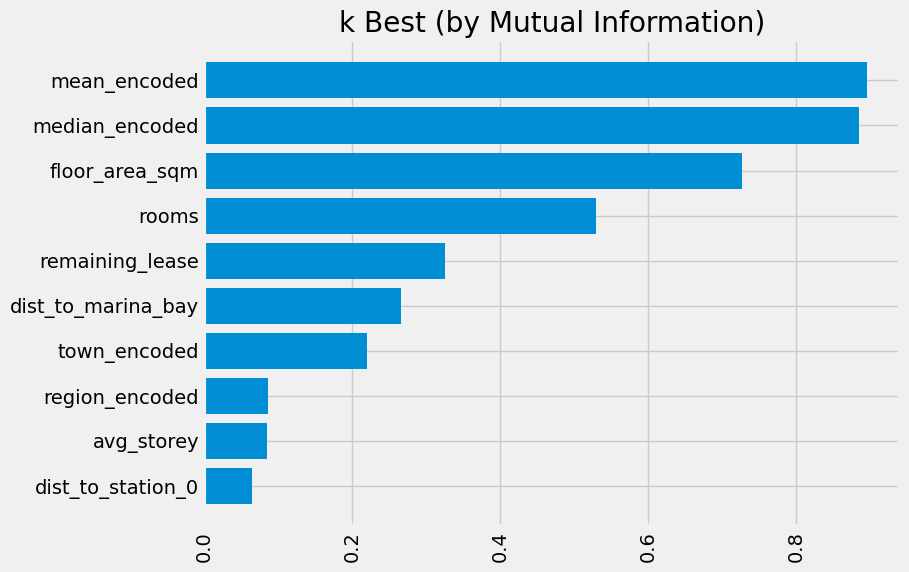

In [40]:
X_df = pd.DataFrame(X, columns=X_unscaled.columns)
kbest = SelectKBest(score_func=mutual_info_regression, k='all')
kbest.fit(X_df, y)
kbest = pd.DataFrame(np.round(kbest.scores_,3), index=kbest.get_feature_names_out(kbest.feature_names_in_), columns=['Mutual Info Score'])
kbest = kbest.sort_values(by=['Mutual Info Score'], ascending=True)
plt.figure(figsize=(8,6))
plt.title('k Best (by Mutual Information)')
plt.barh(kbest.index, kbest['Mutual Info Score'].squeeze())
plt.xticks(rotation=90)
plt.show()

Lasso (L1) regularisation to determine less important features
* To help us determine the optimal penalty term, $\alpha$, LassCrossValidation is used.
* The penalty term will help reduce less important features nearer to a zero value.

In this case, we see that the median encoded feature and label encoded features have turned negative and headed to 0.

Similarly rooms which should be a positive weight has also turned negative instead. This could likely be due to its collinearity with floor_area_sqm

LassoCV Alpha: 21.959
R2 score: 0.867


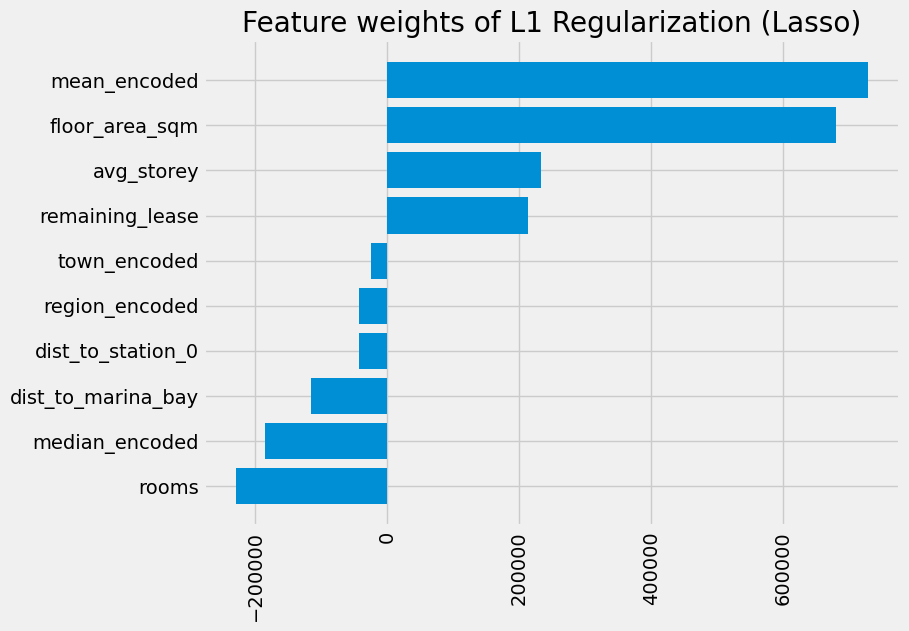

In [41]:
# LassoCV here uses crossvalidation to determine the optimum alpha (penalty value)
lr_reg1 = LassoCV(random_state=42)
lr_reg1.fit(X_train, y_train)
r2 = r2_score(y_test, lr_reg1.predict(X_test))
print(f'LassoCV Alpha: {np.round(lr_reg1.alpha_,3)}')
print(f'R2 score: {np.round(r2,3)}')

feature_weights = pd.DataFrame(lr_reg1.coef_, index=X_unscaled.columns, columns=['feature_weights'])
feature_weights = feature_weights.sort_values(by=['feature_weights'], ascending=True)

plt.figure(figsize=(8,6))
plt.title('Feature weights of L1 Regularization (Lasso)')
plt.barh(feature_weights.index, feature_weights['feature_weights'])
plt.xticks(rotation=90)
plt.show()

#### Final selection of features

Based on the EDA, KBest and LassoCV done so far, the following features will be excluded:
* rooms (to utilise in mean encoding instead)
* dist_to_station
* median_encoded 
* town_encoded 
* region_encoded 

Mean encoding works the best, hence we will not consider the label encoded features and median encoded prices.

In [42]:
X_unscaled = train_df[['floor_area_sqm', 'remaining_lease', 'avg_storey', 'dist_to_marina_bay', 'mean_encoded']] 
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### <div id="2.3">2.3 Model Selection</div>
I will compare the following models in general, before hyperparameter tuning
* SGD Regressor
* Decision Tree Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

I will fit them onto the training set (80%) of the data, then compare them on the test set (remaining 20%)

In [54]:
models = {'SGD Regressor' : SGDRegressor(random_state=42),
          'Tree Regressor' : DecisionTreeRegressor(random_state=42),
          'Random Forest Regressor' : RandomForestRegressor(random_state=42), 
          'Gradient Boosting Regressor' : GradientBoostingRegressor(random_state=42),
          'XGBoost' : xgb}

initial_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    mae = mean_absolute_error(y_test, model.predict(X_test))
    mse = mean_squared_error(y_test, model.predict(X_test))
    r2 = str(round(r2,3))
    mae = str(int(mae))
    mse = str(int(mse))
    initial_results[name] = [r2, mae, mse]

pd.DataFrame(initial_results, index=['r2_score', 'Mean absolute error', 'Mean squared error'])

NameError: name 'X_train' is not defined

The ensemble models (Random Forest and Gradient Boosting) tend to perform better. 
I will narrow down to tune these two models for now.

#### Feature importances
Note that feature importances are impurity based, and can biased towards high cardinality features. (in this case the mean encoded feature)

Feature importances are only useful here in identifying the features that contribute to the prediction, but they do not indicate how important they are to future predictions.

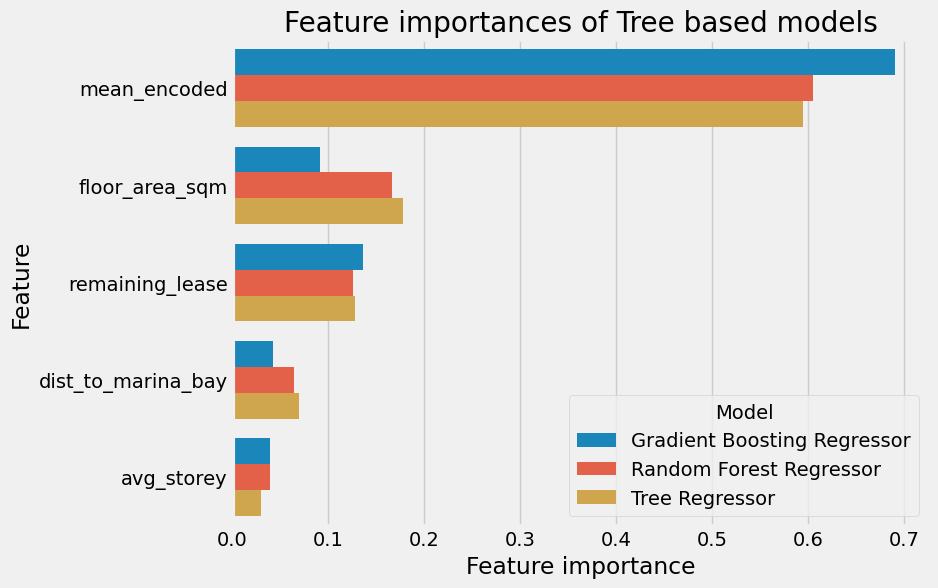

In [44]:
feature_importances = {}
for name, model in models.items():
    if name == 'SGD Regressor': # Impurity based, cannot be used to evaluate the gradient descent regressor
        continue
    feature_importances[name]= np.round(model.feature_importances_, 3)

feature_importances = pd.DataFrame(feature_importances, index=X_unscaled.columns).reset_index()
feature_importances = feature_importances.melt(id_vars='index').sort_values(by=['value'], ascending=False)
feature_importances.columns = ['Feature', 'Model', 'Feature importance']

plt.figure(figsize=(8,6))
plt.title('Feature importances of Tree based models')
sns.barplot(data=feature_importances, y='Feature', x='Feature importance', orient='h', hue='Model')
plt.show()

#### Permutation importances (a better alternative for tree-based models)
The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled.
* Not only is permutation importance model agnostic, it helps us understand how a model is currently using a certain feature.
* This is done simply by shuffling the rows within one feature at a time and measure the difference in our desired score (R2) due to the shuffling.

"impurity-based feature importance of random forests suffers from being computed on statistics derived from the training dataset: the importances can be high even for features that are not predictive of the target variable, as long as the model has the capacity to use them to overfit."  <a href="https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py">source</a>

C:\Users\stell\AppData\Local\Temp\ipykernel_12840\4285494686.py:23: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.get_shared_x_axes().join(ax1, ax2)


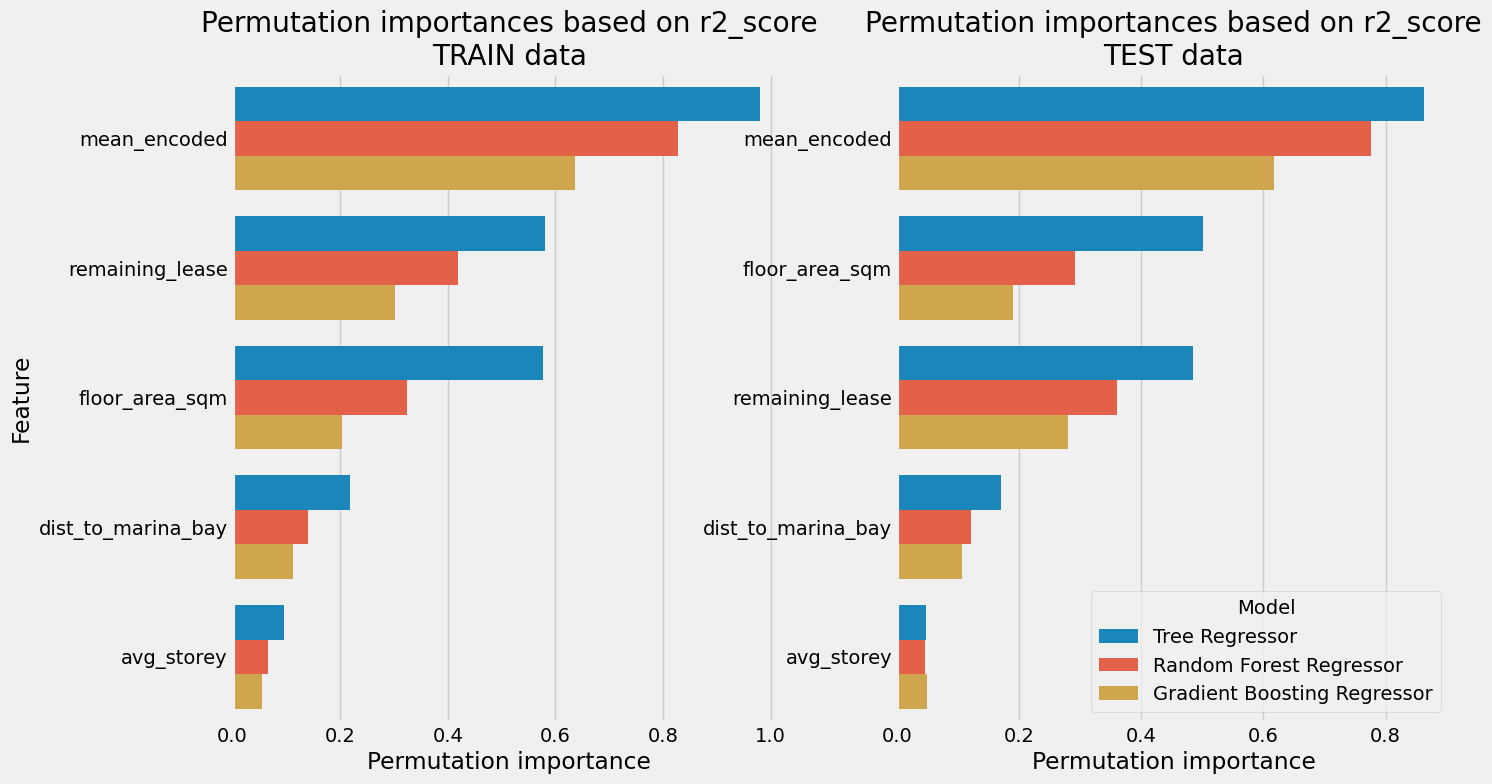

In [45]:
dataset_holder = [(X_train, y_train), (X_test, y_test)]
permutation_importances = [dict(), dict()]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,8))

for dic, dataset, ax in zip(permutation_importances, dataset_holder, (ax1,ax2)):
    for name, model in models.items():
        if name == 'SGD Regressor': # Impurity based, cannot be used to evaluate the gradient descent regressor
            continue
        result = permutation_importance(model, dataset[0], dataset[1],
                                        scoring='r2',
                                        n_repeats=10,
                                        random_state=42)
        dic[name]= np.round(result.importances_mean,3)

    permutation_importance_set = pd.DataFrame(dic, index=X_unscaled.columns).reset_index()
    permutation_importance_set = permutation_importance_set.melt(id_vars='index').sort_values(by=['value'], ascending=False)
    permutation_importance_set.columns = ['Feature', 'Model', 'Permutation importance']

    ax = sns.barplot(data=permutation_importance_set, y='Feature', x='Permutation importance', orient='h', hue='Model', ax=ax)

# Remove legend on ax1, and share axis on ax2
ax1.get_legend().remove()
ax2.get_shared_x_axes().join(ax1, ax2)
# ax2.axes.yaxis.set_ticks([])
ax2.set_ylabel('')

ax1.set_title('Permutation importances based on r2_score\nTRAIN data')
ax2.set_title('Permutation importances based on r2_score\nTEST data')
plt.show()

Compared to the feature importances, we can now see that the other features have a higher weightage now. This is good as it shows that my model is not overly reliant on the mean encoding as suggested by feature importances that can be biased against high cardinality features.

### <div id="2.4">2.4 Hyperparameter tuning</div>
Randomized Search Cross-Validation to tune the hyperpameters for the top 2 models

#### Random Forest Regressor

In [46]:
param_distributions = {'max_depth' : [3,5],
                       'n_estimators' : [50,100,150],
                       'min_samples_leaf' : [5,10,15],
                       'max_features': [None, 'sqrt', 'log2']
                       }

random_cv = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best R2 score', np.round(random_cv.best_score_,3))
best_rfr = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 100, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 5}
Best R2 score 0.878


#### Gradient Boosting Regressor

In [47]:
param_distributions = {'max_depth' : [3,5],
                       'n_estimators' : [50,100,150],
                       'learning_rate' : [0.01,0.1,1],
                       'max_features': [None, 'sqrt', 'log2']
                       }

random_cv = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best R2 score', np.round(random_cv.best_score_,3))
best_gbc = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 150, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
Best R2 score 0.943


### Test on subsequent month's data (Unseen data)

In [48]:
test_df = pd.read_csv('static/test.csv', index_col=0)

# Use previous dictionary of the town and rooms for mean encoding
mean_encoded = mean_encoder.transform(test_df)
test_df = pd.concat([test_df, mean_encoded], axis =1)
test_df = test_df[['resale_price','floor_area_sqm', 'remaining_lease', 'avg_storey', 'dist_to_marina_bay', 'mean_encoded']]
display(test_df.head())
print(test_df.shape)

,resale_price,floor_area_sqm,remaining_lease,avg_storey,dist_to_marina_bay,mean_encoded
_id,,,,,,
156373,538000.0,93.0,56.166667,11.0,9.93,646903.432584
156394,470000.0,92.0,53.583333,2.0,9.99,561132.186441
156395,985000.0,112.0,85.916667,11.0,9.33,701226.792453
156396,635000.0,118.0,56.083333,2.0,9.58,701226.792453
156397,740000.0,122.0,61.583333,5.0,10.18,701226.792453


(395, 6)


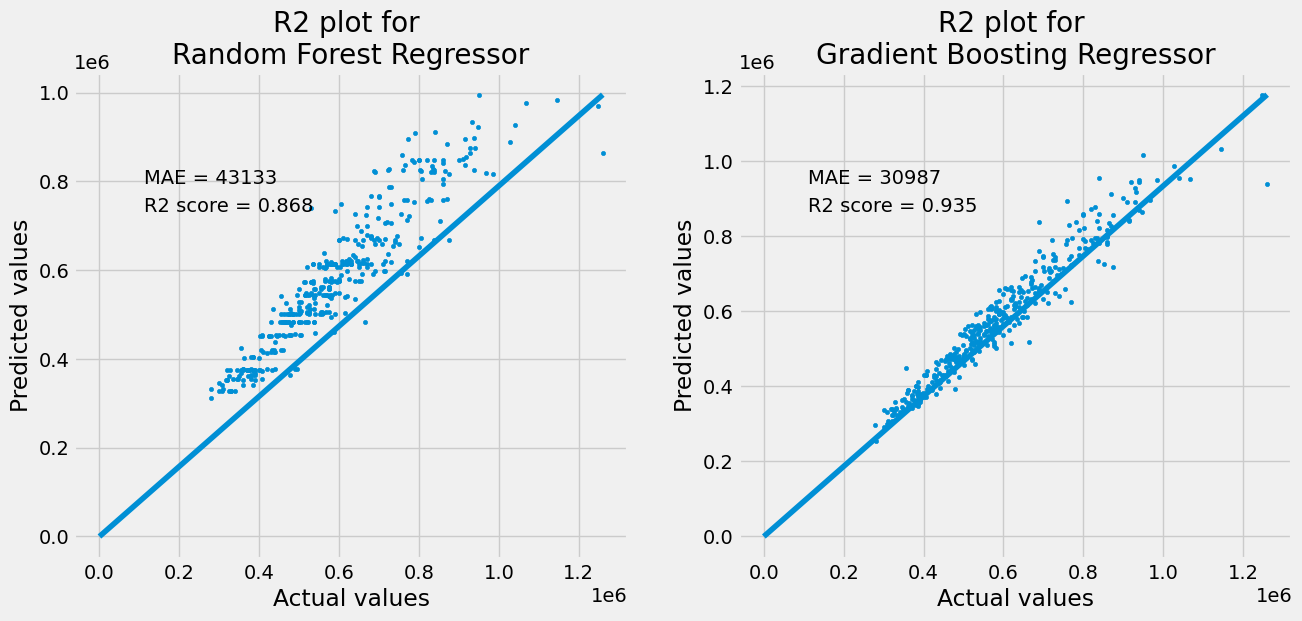

In [49]:
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
X_test = scaler.transform(X_test)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,6))

chosen_models = {best_rfr: ax1, best_gbc: ax2}

for model, ax in chosen_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    ax.scatter(y_test, y_pred , marker='.')
    ax.set_xlabel('Actual values')
    ax.set_ylabel('Predicted values')
    ax.plot([0,max(y_test)], [0, max(y_pred)])
    ax.annotate(f'R2 score = {np.round(r2,3)}', (50,250), xycoords='axes points')
    ax.annotate(f'MAE = {int(mae)}', (50,270), xycoords='axes points')

ax1.set_title(f'R2 plot for \nRandom Forest Regressor')
ax2.set_title(f'R2 plot for \nGradient Boosting Regressor')
plt.show()


## <div id="3">3. Conclusions</div>
It would have been possible to obtain higher scores for each regressor if the max_depth was not limited at 5. However, it would be introducing possible overfitting.

Based on the scores
* The random forest regressor has a bias to overestimate resale prices, the accuracy is still decently above 85%.
* The gradient boosting regressor however has a better fit with a high R2 score and lower MAE.

### Exporting the objects for deployment

In [50]:
# model_version = input(f'Name save file for model {best_gbc}\n')

# print(f"Scaler object saved as {joblib.dump(scaler, f'models/scaler_{model_version}.joblib')}")
# print(f"Mean encoder object as{joblib.dump(mean_encoder, f'models/mean_encoder_{model_version}.joblib')}")
# print(f"Mean encoding Json exported as {mean_encoder.export_to_json(f'models/encoding_dict_{model_version}.json')}")
# print(f"ML model saved as {joblib.dump(best_gbc, f'models/gbc_{model_version}.joblib')}")

Scaler object saved as ['models/scaler_2023_06.joblib']
Mean encoder object as['models/mean_encoder_2023_06.joblib']
Mean encoding Json exported as static/encoding_dict_2023_06.json
ML model saved as ['models/gbc_2023_06.joblib']
